# Introduction

In the notebook below, we demonstrate how to read matrix-array datasets collected using us4R platform, reconstruct a 3D volume from it, and visualize it. This notebook also serves as an example of how to run ARRUS form offline image reconstruction. 

We assume here that the user has an NVIDIA CUDA-compatible graphics card and has already installed the required packages (see `requirements.txt`). 

In [ ]:
import urllib.request
import pickle
import numpy as np
from arrus.utils.imaging import *
import cupy as cp
import matplotlib.pyplot as plt
import os

<table border="1">
    <tr>
        <td>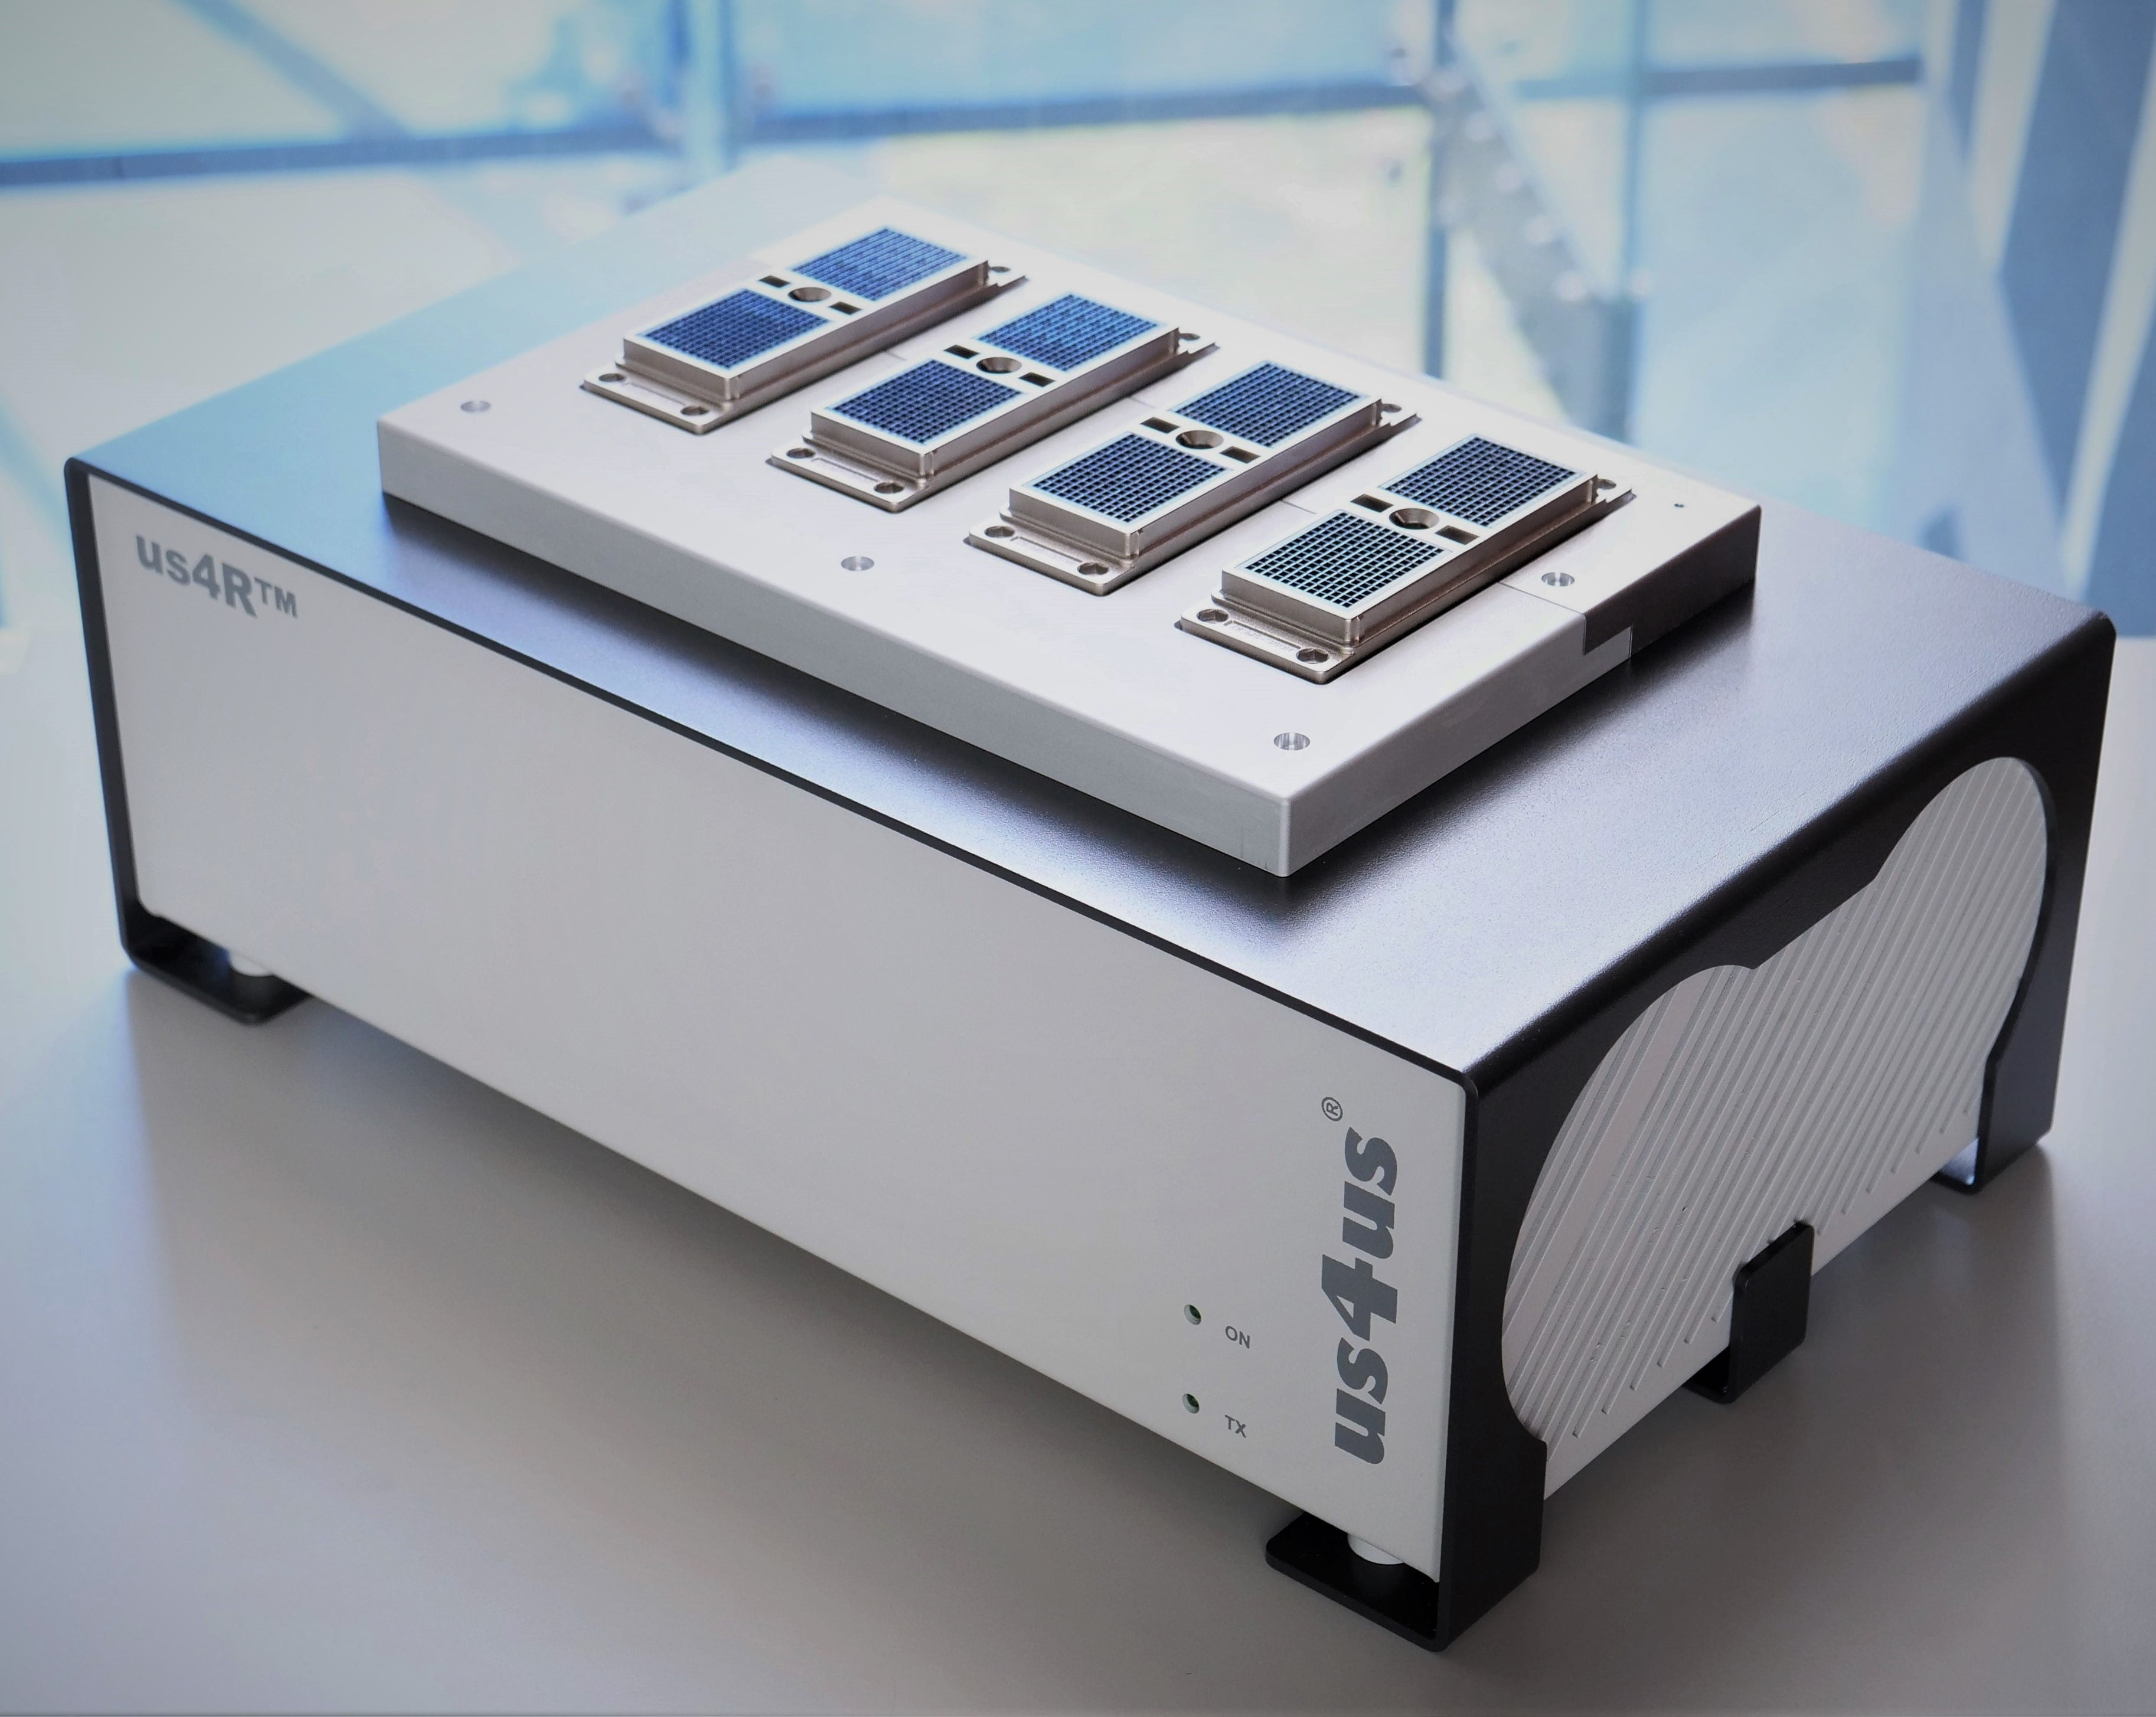</td>
        <td>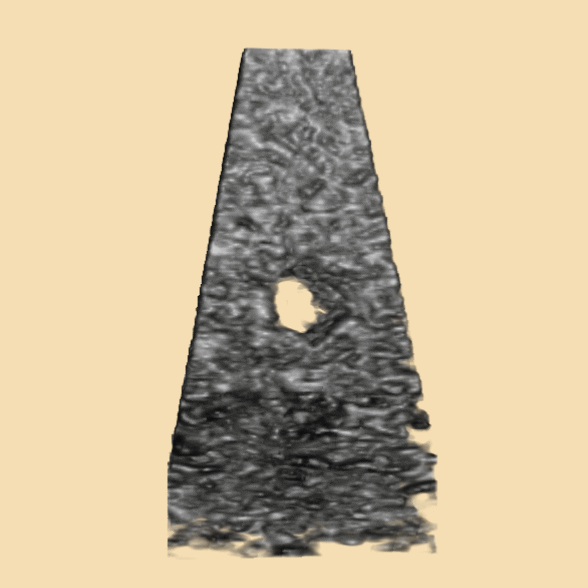</td>
    </tr>
</table>

# Reading input data

The below cell downloads and reads example dataset. Change the `filepath` to load your own dataset.

In [ ]:
filename = "data.pkl"
if os.path.exists(filename):
    print(f"The file '{filename}' already exists. Skipping download.")
else:
    print(f"Downloading '{filename}'...")
    urllib.request.urlretrieve("https://www.dropbox.com/scl/fi/x5w2t5i93w5x10cbsqai3/3d_cyst3_ats560h.pkl?rlkey=hbm1nmppm0vshfjzsbue88jrv&st=ixjedeyk&dl=1", filename)
    print("Download complete.")
    
filepath = os.path.join("./", filename)
with open(filepath, "rb") as f:
    f = pickle.load(f)
f.keys()

The dataset includes:
- `data`: a sequence of data arrays collected at the consecutive time steps,
- `metadata`: metadata that describes the `data`. 

In [ ]:
data = f["data"]
metadata = f["metadata"]

For the datasets we provide, multiple data arrays are collected at each time point, specifically:
- 2D B-modes from the planes $x = 0$ and $y = 0$,
- raw RF data.

For each of these data types, relevant metadata is available. For example, we can check the array shapes using the `input_shape` property:

In [ ]:
data_timestep0 = data[0]
print(f"B-mode OXZ shape: {metadata[0].input_shape}")
print(f"B-mode OYZ shape: {metadata[1].input_shape}")
print(f"Raw channel data shape: {metadata[2].input_shape}")

In the following sections of the notebook, we will use raw channel data metadata to reconstruct and visualize 3D volume:

In [ ]:
rf_metadata = f["metadata"][-1]
rf_data = np.stack(list(zip(*f["data"]))[-1])

# Volume reconstruction

The cell below contains the parameters for volume reconstruction. From the notebook's user's perspective, the most important parameters are `x_grid`, `y_grid`, and `z_grid`, which define the $OX$, $OY$, and $OZ$ coordinates of the reconstructed voxels (`y_grid` $\times$ `x_grid` $\times$ `z_grid` is reconstructed).

The remaining parameters are part of the metadata and should not be modified to ensure correct results.

In [ ]:
# Imaging grid
y_grid = np.arange(-8e-3, 8e-3, 0.2e-3)  # [m]
x_grid = np.arange(-8e-3, 8e-3, 0.2e-3)  # [m]
z_grid = np.arange(0e-3, 40e-3, 0.2e-3)  # [m]

# Data specific for the matrix_array example (NOTE: will be included in the metadata model in the future)
# a list of TX focus depths, applied in the TX/RX sequence [m]
tx_focus = rf_metadata.data_description.custom["matrix_array_tx_focus"]
# a list of TX angles (OXZ plane) applied in the TX/RX sequence [rad]
tx_ang_zx = rf_metadata.data_description.custom["matrix_array_tx_ang_zx"]
# a list of TX angles (OYZ plane) applied in the TX/RX sequence [rad]
tx_ang_zy = rf_metadata.data_description.custom["matrix_array_tx_ang_zy"]
# The assumed speed of sound.
speed_of_sound = rf_metadata.context.medium.speed_of_sound

# The TX/RX sequence used for RF data acquisition.
sequence = rf_metadata.context.sequence
# Sample range: first, last sample.
start_sample, end_sample = sequence.ops[0].rx.sample_range
n_samples = end_sample - start_sample

In [ ]:
tx_focus

In [ ]:
tx_ang_zx

In [ ]:
tx_ang_zy

The next cell sets up the pipeline for reconstructing a 3D volume from raw channel data.

The pipeline consists of a sequence of operations to be performed on the RF data. The input for `step[i]` is the output from `step[i-1]`.

In [ ]:
pipeline = Pipeline(
    steps=(
        # Reorder data from the physical order (i.e. depending on 
        # the us4R hardware) to logical order (i.e. (sequence, TX, RX, samples).
        #
        # Input:
        # - array with hardware-specific shape
        # - data type: int16
        # Output:
        # - array with shape (n_seq, n_tx, n_channels, n_samples)
        # - data type: int16
        RemapToLogicalOrder(),
        # Swap the last two axes (-> n_channels, n_samples)
        #
        # Input:
        # - array with shape (n_seq, n_tx, n_samples, n_channels)
        # - data type: int16
        # Output:
        # - array with shape (n_seq, n_tx, n_channels, n_samples)
        # - data type: int16
        Transpose(axes=(0, 1, 3, 2)),
        # Reshape the channels' axis to (n_y, n_x).
        # The n_x axis corresponds to the fastest changing dimension
        # (i.e. elements that are assigned to the adjacent channels).
        #
        # Input:
        # - array with shape (n_seq, n_tx, n_channels, n_samples)
        # - data type: int16
        #
        # Output:
        # - array with shape (n_seq, n_tx, n_y, n_x, n_samples)
        # - data type: int16
        Reshape(1, len(sequence.ops), 32, 32, n_samples),
        # Band-pass (50%-150%) FIR filter.
        #
        # Input:
        # - array with shape (n_seq, n_tx, n_samples, n_channels)
        # - data type: int16
        # Output:
        # - array with shape (n_seq, n_tx, n_channels, n_samples)
        # - data type: float32
        BandpassFilter(),
        # ---  Digital Down Conversion:
        #
        # - Demodulate for center frequency 3 MHz (based on metadata).
        # - low-pass (FIR) filter and decimation
        #
        # Input:
        # - array with shape (n_seq, n_tx, n_y, n_x, n_samples)
        # - data type: float32
        # Output:
        # - array with shape (n_seq, n_tx, n_y, n_x,
        #                     n_samples/decimation_factor)
        # - data type: complex64
        DigitalDownConversion(
            decimation_factor=30,
            fir_order=64
        ),
        # Reconstruct low-resolution images.
        # The below operation reconstructs directly on the target mesh,
        # that is, the output of this stage is a volume, which the
        # individual points correspond to the physical position
        # in the sonified area (pixels).
        # Input:
        # - array with shape (n_seq, n_tx, n_y, n_x,
        #                     n_samples/decimation_factor)
        # - data type: complex64
        #
        # Output:
        # - array with shape (n_seq, n_pix_y, n_pix_x, n_pix_z)
        # - data type: complex64
        ReconstructLri3D(    
            x_grid=x_grid, y_grid=y_grid, z_grid=z_grid,
            tx_foc=tx_focus,
            tx_ang_zx=tx_ang_zx, 
            tx_ang_zy=tx_ang_zy,
            speed_of_sound=speed_of_sound
        ),
        # Remove axes with size == 1
        # Input:
        # - array with shape (n_seq == 1, n_pix_y, n_pix_x, n_pix_z)
        # - data type: complex64
        # Output:
        # - array with shape (n_pix_y, n_pix_x, n_pix_z)
        # - data type: complex64
        Squeeze(),
        # Get the amplitude of the IQ data.
        # Input:
        # - array with shape (n_pix_y, n_pix_x, n_pix_z)
        # - data type: complex64
        # Output:
        # - array with shape (n_pix_y, n_pix_x, n_pix_z)
        # - data type: float32
        EnvelopeDetection(),
        # Log compress to B-mode image.
        #
        # Input and Output:
        # - array with shape (n_pix_y, n_pix_x, n_pix_z)
        # - data type: float32
        LogCompression()
    ),
    placement="/GPU:0"
)

The pipeline needs to be initialized using the metadata descrbing the input RF data:

In [ ]:
pipeline.prepare(rf_metadata)

Next, we can process the data on the GPU using the pipeline:

In [ ]:
# Transfer RF data to GPU
rf_data_gpu = cp.asarray(rf_data)
# Process the data using the pipeline.
bmode_gpu = pipeline.process(rf_data_gpu)[0]
# Transfer the output B-mode from the GPU to the host RAM memory.
bmode = bmode_gpu.get()

# Visualization

In [ ]:
ny, nx, nz = bmode.shape

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.set_title("OXZ B-mode")
ax0.set_ylabel("OZ (mm)")
ax0.set_xlabel("OX (mm)")
ax0.imshow(bmode[ny//2, :, :].T, cmap="gray", vmin=0, vmax=80, extent=np.asarray([np.min(x_grid), np.max(x_grid), np.max(z_grid), np.min(z_grid)])*1e3)

ax1.set_title("OYZ B-mode")
ax1.set_ylabel("OZ (mm)")
ax1.set_xlabel("OY (mm)")
ax1.imshow(bmode[:, nx//2, :].T, cmap="gray", vmin=0, vmax=80, extent=np.asarray([np.min(y_grid), np.max(y_grid), np.max(z_grid), np.min(z_grid)])*1e3)

# Visualization 3D (interactive)

In [ ]:
import vtk
import panel as pn
pn.extension('vtk')


camera = {
    "position": [0, -500, 0], 
    "focalPoint": [50, 50, 100], 
    "viewUp": [0, 0, -1], 
    "viewAngle": 30, 
}

vol = bmode.copy()
# removing voxels with low amplitude
vol[vol < 20] = np.nan

# rendering
volume = pn.pane.VTKVolume(
    vol, 
    camera=camera,
    origin=(0,0,0),
    width=300, 
    height=300, 
    spacing=(1,1,1), 
    interpolation='nearest', 
    edge_gradient=0.5,
    sampling=0.5,
    orientation_widget=False,
    colormap="erdc_rainbow_dark",
    display_volume=True,
    display_slices=False,
    shadow=True,
    ambient=0.5,
    diffuse=1,
    specular=1,
    specular_power=8,
    render_background='#808080'
)
pn.Row(volume.controls(jslink=True), volume)